In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
# Install all the required dependencies (libraries) for the project from the requirements.txt file
!pip install -r requirements.txt
!pip install roboflow
!pip install blinker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 41.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.8 MB/s eta 0:00:00
Reason for being yanked: The Windows wheels, under some conditions, caused segfaults in unrelated user code.  Due to this we deleted the Windows wheels to prevent these segfaults, however this caused greater disruption as pip then began to try (and fail) to build 3.9.1 from the sdist on Windows which impacted far more users.  Yanking the whole release is the only tool available to eliminate these failures without changes to on the user side.  The sdist, OSX wheel, and manylinux wheels are all functional and there are no critical bugs in the release.   Downstream packagers should not ya

In [ ]:
import os
import shutil

from roboflow import Roboflow
import torch
import yaml

In [ ]:
from IPython.display import clear_output

# Set HOME to get your current working directory
HOME = os.getcwd()
print("HOME directory is set to:", HOME)

# Download the YOLO model
%cd {HOME}
!git clone https://github.com/ultralytics/ultralytics.git
%cd {HOME}/ultralytics
!pip install -e .

# Clear the output to keep it clean
clear_output()

# Run checks for the YOLO model
import ultralytics
ultralytics.checks()

Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.4/112.6 GB disk)


In [ ]:
# Making and moving into 'datasets' directory
os.makedirs(f'{HOME}/datasets', exist_ok=True)
%cd {HOME}/datasets

rf = Roboflow(api_key="DVSACmCnjnq3Yb7MimiW")
project = rf.workspace("vit16").project("vialdetection-fsax5")
dataset = project.version(5).download("yolov8")

/content/drive/MyDrive/Colab Notebooks/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.3.18, to fix: `pip install ultralytics==8.0.196`
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to VialDetection-5 in yolov8:: 100%|██████████| 7166/7166 [00:57<00:00, 124.29it/s]


In [ ]:
# Create folders for storing the data
def calculate_next_folder(base_dir, base_name):
    # List all directories in the base_dir
    existing_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Filter out directories that start with the base name (e.g., 'train')
    dirs = [d for d in existing_dirs if d.startswith(base_name)]

    # Find the highest number by extracting digits from directory names
    nums = [int(d[len(base_name):]) for d in dirs if d[len(base_name):].isdigit()]

    if base_name not in dirs:
        return base_name
    nums.append(1)
    # Determine the next folder number
    next_num = max(nums, default=1) + 1

    # Return the new folder name
    return f"{base_name}{next_num}"

def get_next_folder(base_name):
    base_dir_str =f'{HOME}/ultralytics/runs/segment/'
    os.makedirs(base_dir_str, exist_ok=True)
    base_dir = os.path.join(base_dir_str)
    return calculate_next_folder(base_dir, base_name)

train_folder_name = get_next_folder('train')
predict_folder_name = get_next_folder('predict')
val_folder_name = get_next_folder('val')

In [ ]:
# Check if CUDA is available (for NVIDIA GPUs) or MPS (for Apple Silicon Macs), and select the appropriate device
if torch.cuda.is_available():
    device = torch.device("cuda")  # use CUDA (NVIDIA GPU)
    print("CUDA is available. Using GPU.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")   # use MPS (Apple Silicon)
    print("MPS is available. Using Apple Silicon GPU.")
else:
    device = torch.device("cpu")   # fallback to CPU
    print("Neither CUDA nor MPS is available. Using CPU.")

train_folder_name = get_next_folder('train')

folder_path = f'{HOME}/datasets/{train_folder_name}/{train_folder_name}'

# Check if the folder exists, then delete it
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Folder '{folder_path}' has been deleted.")

CUDA is available. Using GPU.
Folder '/content/drive/MyDrive/Colab Notebooks/datasets/train5/train5' has been deleted.


In [ ]:
# Update the data.yaml file to have the appropriate information about our dataset download
file_path = '../datasets/VialDetection-5/data.yaml'

# Open and load the YAML file
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

# Modify the 'train' and 'val' paths
data['train'] = 'train/images'
data['val'] = 'valid/images'

# Save the updated YAML file
with open(file_path, 'w') as file:
    yaml.dump(data, file)

print("YAML file updated successfully!")
print({train_folder_name})

YAML file updated successfully!
{'train5'}


In [ ]:
#get the yolo model
from ultralytics import YOLO
model = YOLO(f'{HOME}/yolov8l.pt')

In [ ]:
#Training loop
model.train(
   data=f'{HOME}/datasets/VialDetection-5/data.yaml',  # Path to data.yaml
   epochs=30,  # Number of epoch
   imgsz=224,   # Image size
   batch=64,    # Batch size
   name=f'{train_folder_name}',  # Name for this training run
   project=f'{train_folder_name}',  # Save directory
   workers=20,   # Number of workers for data loading
   device=device,  # Set the correct device (MPS, CUDA, or CPU)
)

New https://pypi.org/project/ultralytics/8.3.43 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Colab Notebooks/yolov8l.pt, data=/content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/data.yaml, epochs=30, time=None, patience=100, batch=64, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=20, project=train5, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save

100%|██████████| 755k/755k [00:00<00:00, 26.9MB/s]


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/train/labels... 3132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3132/3132 [01:15<00:00, 41.68it/s]


train: New cache created: /content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/valid/labels... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:07<00:00, 41.19it/s]


val: New cache created: /content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/valid/labels.cache
Plotting labels to train5/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to train5/train5
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      5.54G      1.683      2.592      1.688        133        224: 100%|██████████| 49/49 [00:47<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.16s/it]

                   all        297        306      0.274      0.569      0.291      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.49G      1.431      1.611       1.56        118        224: 100%|██████████| 49/49 [00:40<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


                   all        297        306      0.279       0.55      0.344        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.48G      1.481      1.649       1.64        133        224: 100%|██████████| 49/49 [00:40<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        297        306       0.21      0.467      0.253      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.49G      1.474      1.558      1.634        120        224: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all        297        306      0.386      0.593       0.42      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.47G      1.428      1.451        1.6        146        224: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.51s/it]

                   all        297        306      0.564      0.597      0.605      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.48G      1.391      1.372       1.58        121        224: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]

                   all        297        306      0.563      0.687      0.646      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.48G      1.356      1.265      1.557        122        224: 100%|██████████| 49/49 [00:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all        297        306      0.706      0.691      0.746      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.48G      1.338      1.201      1.541        111        224: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        297        306      0.592      0.769      0.745      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       5.5G      1.321      1.158      1.528        116        224: 100%|██████████| 49/49 [00:43<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all        297        306      0.621      0.766      0.731      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.48G      1.288      1.126      1.505        140        224: 100%|██████████| 49/49 [00:44<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]

                   all        297        306      0.703      0.719      0.786      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.48G      1.264      1.071       1.49        133        224: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        297        306      0.751       0.81      0.832      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.48G       1.26      1.042      1.478        128        224: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all        297        306      0.808      0.787      0.865      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.48G      1.223     0.9885      1.461        127        224: 100%|██████████| 49/49 [00:43<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]

                   all        297        306      0.708      0.738      0.748      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.48G      1.205     0.9655       1.46        140        224: 100%|██████████| 49/49 [00:42<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all        297        306      0.788      0.866      0.904      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.48G      1.191     0.9332      1.447        111        224: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        297        306      0.783      0.868      0.899      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.48G      1.185      0.907      1.436        129        224: 100%|██████████| 49/49 [00:39<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        297        306      0.867       0.82      0.913      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.46G      1.164     0.8786      1.422        131        224: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all        297        306      0.764      0.883      0.895      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.48G      1.141      0.838      1.405        121        224: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]

                   all        297        306      0.798      0.866      0.885      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.48G      1.113      0.805      1.384        108        224: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        297        306      0.815      0.812      0.881      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.48G      1.112       0.81      1.394        138        224: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

                   all        297        306      0.796      0.856      0.898      0.644


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.48G      1.045     0.5941      1.392         62        224: 100%|██████████| 49/49 [00:41<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]

                   all        297        306      0.871      0.839      0.907      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.48G      1.001     0.5391      1.358         60        224: 100%|██████████| 49/49 [00:40<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        297        306      0.876      0.874      0.916      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.48G     0.9954     0.5116       1.35         60        224: 100%|██████████| 49/49 [00:45<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.54s/it]

                   all        297        306      0.849      0.846      0.895      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.47G     0.9543     0.4951      1.325         62        224: 100%|██████████| 49/49 [00:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all        297        306      0.862      0.892      0.929      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.49G     0.9201     0.4697        1.3         60        224: 100%|██████████| 49/49 [00:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        297        306      0.809      0.892      0.891       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.48G     0.9119     0.4408      1.287         61        224: 100%|██████████| 49/49 [00:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all        297        306      0.817      0.871      0.909      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.48G     0.8751     0.4242      1.252         62        224: 100%|██████████| 49/49 [00:42<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]

                   all        297        306      0.841      0.894      0.915      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.49G     0.8767     0.4142      1.252         60        224: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all        297        306      0.855      0.885      0.918      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.47G     0.8427     0.3926      1.228         64        224: 100%|██████████| 49/49 [00:38<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all        297        306      0.893      0.901       0.93      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.48G      0.823     0.3848      1.213         61        224: 100%|██████████| 49/49 [00:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all        297        306      0.884      0.903      0.927      0.689



30 epochs completed in 0.419 hours.
Optimizer stripped from train5/train5/weights/last.pt, 87.6MB
Optimizer stripped from train5/train5/weights/best.pt, 87.6MB

Validating train5/train5/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43,613,547 parameters, 0 gradients, 164.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


                   all        297        306      0.893        0.9      0.931      0.697
             10ml Vial         74         74          1      0.982       0.99      0.689
          125ml Beaker         22         22      0.807      0.762      0.769      0.631
150ml Graduated Cylinder         26         26      0.947      0.885      0.978      0.768
          300ml Beaker         21         21      0.828      0.917      0.886      0.679
35ml Graduated Cylinder         14         14        0.7      0.857      0.911      0.719
           65ml Beaker         16         16      0.857      0.875      0.904      0.696
65ml Graduated Cylinder         33         34      0.919      0.882      0.957      0.696
             65ml Vial         87         87      0.977      0.967      0.993      0.652
 75ml Erlenmeyer Flask         12         12          1      0.977      0.995      0.743
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to train5/

lr/pg0,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg1,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg2,▃▆███▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
metrics/mAP50(B),▁▂▁▃▅▅▆▆▆▆▇▇▆█████▇███████████
metrics/mAP50-95(B),▁▂▁▂▄▄▅▅▅▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇█████
metrics/precision(B),▂▂▁▃▅▅▆▅▅▆▇▇▆▇▇█▇▇▇▇████▇▇▇███
metrics/recall(B),▃▂▁▃▃▅▅▆▆▅▇▆▅▇▇▇█▇▇▇▇█▇███████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x785a6bf30dc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [ ]:
# Save the model and the results
model = YOLO(f'{HOME}/datasets/{train_folder_name}/{train_folder_name}/weights/best.pt')
save_dir = os.path.join(f'{HOME}/ultralytics/runs/segment', val_folder_name)
val_folder_name = get_next_folder('val')
model.val(data=f'{dataset.location}/data.yaml', save_dir=save_dir)

Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43,613,547 parameters, 0 gradients, 164.9 GFLOPs


val: Scanning /content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/valid/labels.cache... 297 images, 0 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.54it/s]


                   all        297        306      0.893      0.901      0.932      0.697
             10ml Vial         74         74          1      0.982       0.99      0.687
          125ml Beaker         22         22      0.807      0.762      0.768      0.631
150ml Graduated Cylinder         26         26      0.947      0.885      0.978      0.768
          300ml Beaker         21         21      0.829      0.922      0.889      0.682
35ml Graduated Cylinder         14         14      0.697      0.857      0.908      0.714
           65ml Beaker         16         16      0.857      0.875      0.906      0.697
65ml Graduated Cylinder         33         34       0.92      0.882      0.957      0.696
             65ml Vial         87         87      0.977      0.967      0.993      0.652
 75ml Erlenmeyer Flask         12         12          1      0.977      0.995      0.743
Speed: 0.1ms preprocess, 5.8ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /conten

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x785a4cf76140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [ ]:
#Download model
from google.colab import files
files.download(f'{HOME}/datasets/{train_folder_name}/{train_folder_name}/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

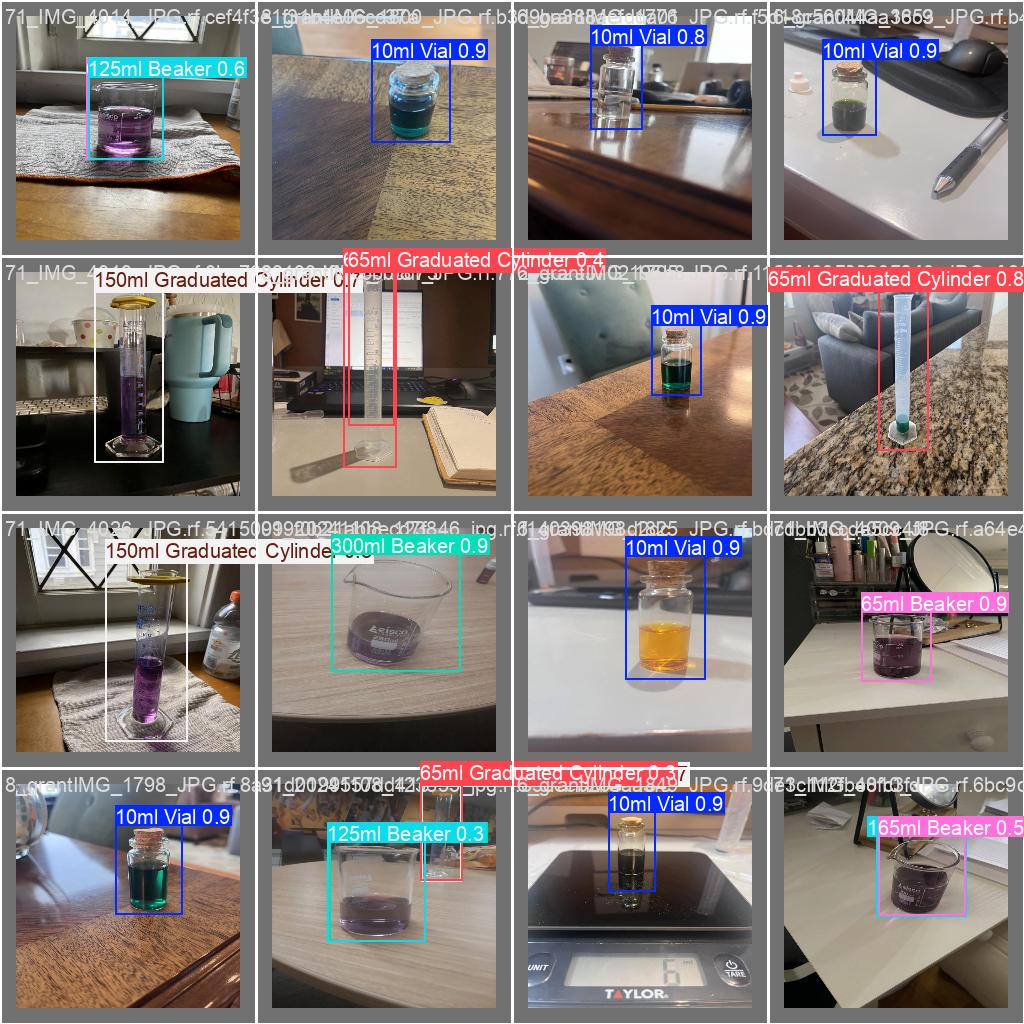

In [ ]:
# Display the results for the training data
from IPython.display import display, Image
display(Image(filename=f"{HOME}/datasets/{train_folder_name}/{train_folder_name}/val_batch0_pred.jpg", width=600))

In [ ]:
# Run predictions on the data you've reserved for testing
predict_folder_name = get_next_folder('predict')

# Inferencing with the model
model_path = os.path.join(HOME, f"/content/drive/MyDrive/Colab Notebooks/datasets/{train_folder_name}/{train_folder_name}/weights/best.pt")
source_path = os.path.join(dataset.location, "test/images")

# Load the YOLO model from the trained weights
model = YOLO(model_path)
save_dir = os.path.join(f'{HOME}/ultralytics/runs/segment', predict_folder_name)
# Run predictions on the test dataset
results = model.predict(
    source=source_path,  # Path to test images
    conf=0.5,  # Confidence threshold
    save=True,  # Save the predictions (output images)
    save_dir=save_dir
)


image 1/148 /content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/test/images/0_0ac03bf9-44ef-412c-8b74-6d07f336ca66_png.rf.bd37dd7bb8eafb1218aff033c67eaf68.jpg: 224x224 1 10ml Vial, 18.4ms
image 2/148 /content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/test/images/0_60d15215-bcce-4714-b9e4-e9cb3dbf1908_png.rf.0e90c029a2ebd519ee847614d7d83db1.jpg: 224x224 1 65ml Vial, 36.2ms
image 3/148 /content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/test/images/0_grantIMG_1732_JPG.rf.3cac52afe769413a2bf484cee91529f0.jpg: 224x224 1 65ml Vial, 18.6ms
image 4/148 /content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/test/images/0_grantIMG_1739_JPG.rf.6bf25d7ea2dfb4873f67d7ceef1fb8af.jpg: 224x224 1 65ml Vial, 18.4ms
image 5/148 /content/drive/MyDrive/Colab Notebooks/datasets/VialDetection-5/test/images/0_grantIMG_1741_JPG.rf.a9650b1cc51137f0403e1b39a486b91a.jpg: 224x224 1 65ml Vial, 18.4ms
image 6/148 /content/drive/MyDrive/Colab Notebooks/datasets/VialDete

In [ ]:
# Filter out images where Yolo couldn't find the desired names
class_names = model.names
name_dict = {}
for idx, result in enumerate(results):
    if result.boxes.cls is None:
        continue

    for class_id in result.boxes.cls:
        # Convert tensor to int before indexing `class_names`
        class_name = class_names[int(class_id.item())]
        print(class_name)
        name_dict[f'image_{idx + 1}'] = [class_name]

10ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
65ml Graduated Cylinder
10ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
65ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
10ml Vial
150ml Graduated Cylinder
150ml Graduated Cylinder
150ml Graduated Cylinder
65ml Graduated Cylinder
35ml Graduated Cylinder
35ml Graduated Cylinder
65ml Graduated Cylinder
35ml Graduated Cylinder
35ml Graduated Cylinder
35ml Graduated Cylinder
300ml Beaker
300ml Beaker
300ml Beaker
125ml Beaker
35ml Graduated Cylinder
150ml Graduated Cylinder
35ml Graduated Cylinder
35ml Gra

In [ ]:
# Get the container name
for image_name, name in name_dict.items():

    print(f"{image_name}:")
    print(f"  Container is a {name}")

image_1:
  Container is a ['10ml Vial']
image_2:
  Container is a ['65ml Vial']
image_3:
  Container is a ['65ml Vial']
image_4:
  Container is a ['65ml Vial']
image_5:
  Container is a ['65ml Vial']
image_6:
  Container is a ['65ml Vial']
image_7:
  Container is a ['65ml Vial']
image_8:
  Container is a ['10ml Vial']
image_9:
  Container is a ['10ml Vial']
image_10:
  Container is a ['10ml Vial']
image_11:
  Container is a ['10ml Vial']
image_12:
  Container is a ['65ml Graduated Cylinder']
image_13:
  Container is a ['10ml Vial']
image_14:
  Container is a ['65ml Vial']
image_15:
  Container is a ['65ml Vial']
image_16:
  Container is a ['65ml Vial']
image_17:
  Container is a ['65ml Vial']
image_18:
  Container is a ['65ml Vial']
image_19:
  Container is a ['65ml Vial']
image_20:
  Container is a ['65ml Vial']
image_21:
  Container is a ['65ml Vial']
image_22:
  Container is a ['65ml Vial']
image_23:
  Container is a ['65ml Vial']
image_24:
  Container is a ['65ml Vial']
image_25:
 